# Natural Language Processing - NLP

In [528]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
import re
import os
from nltk.corpus import stopwords
import nltk
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
tqdm.pandas()
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from pickle import dump
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [489]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Agustín\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Agustín\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [490]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
data = pd.read_csv(url)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


### Step 2: Preprocess the links

Use what we have seen in this module to transform the data to make it compatible with the model we want to train. Segment the URLs into parts according to their punctuation marks, remove stopwords, lemmatize, and so on.

Make sure to conveniently split the dataset into train and test as we have seen in previous lessons.

In [491]:
print(f'''Nan values: 
{data.isna().sum()}''')

Nan values: 
url        0
is_spam    0
dtype: int64


In [492]:
print(f'"y" column values:{data.is_spam.unique()}')

"y" column values:[ True False]


In [493]:
print(f'''Column "y" values count: 
{data.is_spam.value_counts()}''')

Column "y" values count: 
is_spam
False    2303
True      696
Name: count, dtype: int64


In [494]:
def preprocess(text):
  # Eliminamos urls
  text = re.sub(r'[%s]', ' ', text)
  # Pasar el texto a minúscula
  text = text.lower()
  # Solo texto
  text = re.sub(r'[^\w\s]|[\d]', ' ', text)
  # Eliminación de los espacios adicionales
  text = re.sub(r'\s+', ' ', text).strip()                                          # Espacios dobles por espacio, y espacios ini-fin con strip()
  # Elimino http / https / www / com / co
  take_out = ['http', 'https', 'www', 'com', 'co']
  pattern = r'\b(?:' + '|'.join(take_out) + r')\b'                                  # este no me quedo otra que sacarlo de chatgpt, no lo podia hacer andar bien
  text = re.sub(pattern, '', text) 
  # Tokenizamos
  tokens = text.split(' ')
  # Almacenamos las palabras que no son stopwords
  ls_stopwords = stopwords.words('english')
  tokens = [unidecode(token) for token in tokens if token not in ls_stopwords]
  # Lematizamos los tokens
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token)>2]
  return ' '.join(tokens)

In [495]:
data.url[0]

'https://briefingday.us8.list-manage.com/unsubscribe'

In [496]:
data.url = data.url.progress_apply(preprocess)              # igual que apply pero con la barra de progrerso

100%|██████████| 2999/2999 [00:01<00:00, 1835.97it/s]


In [497]:
data.head()

,url,is_spam
0,briefingday manage cribe,True
1,hvper,True
2,briefingday,True
3,briefingday commentform,False
4,briefingday fan,True


In [498]:
print(f'Duplicated values to drop: {data.duplicated().sum()}')
data.drop_duplicates(inplace=True, ignore_index=True)
print(f'Duplicated values after drop them: {data.duplicated().sum()}')

Duplicated values to drop: 724
Duplicated values after drop them: 0


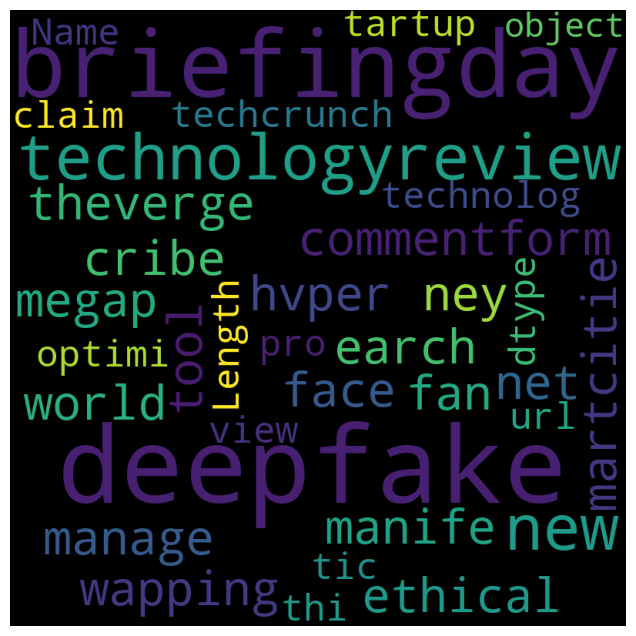

In [499]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 100, min_font_size = 20, random_state = 42)\
    .generate(str(data.url))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [500]:
X_train, X_test, y_train, y_test = tts(data.url, data.is_spam, test_size=0.2, random_state=42)

In [501]:
# Paso a bin los true/false de las 'y'
lab_enc = LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.transform(y_test)

In [502]:
# vectorizamos las 'X'
vectorizer = TfidfVectorizer(min_df=0.001)
X_train_num = vectorizer.fit_transform(X_train)
X_test_num = vectorizer.transform(X_test)

In [503]:
X_train_num, X_test_num

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 9915 stored elements and shape (1820, 1610)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 2153 stored elements and shape (455, 1610)>)

In [504]:
vectorizer.get_feature_names_out()

array(['_copy_', '_fb', 'abacu', ..., 'zoom', 'zoox', 'zuckerberg'],
      dtype=object)

### Step 3: Build an SVM
Start solving the problem by implementing an SVM with the default parameters. Train it and analyze its results.

In [505]:
# Cargo  los datos de train y test
model = SVC(kernel = "rbf", C = 1.0, gamma = 0.5)
model.fit(X_train_num, y_train)
y_test_pred = model.predict(X_test_num)

In [506]:
y_train_pred = model.predict(X_train_num)
print(f'''Train subset report: 
{classification_report(y_train_enc,y_pred=y_train_pred)}''')
print(f'''Test subset report:
{classification_report(y_test_enc,y_pred=y_test_pred)}''')

Train subset report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1638
           1       0.97      0.55      0.71       182

    accuracy                           0.95      1820
   macro avg       0.96      0.78      0.84      1820
weighted avg       0.95      0.95      0.95      1820

Test subset report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       399
           1       0.83      0.36      0.50        56

    accuracy                           0.91       455
   macro avg       0.87      0.67      0.73       455
weighted avg       0.91      0.91      0.90       455



### Step 4: Optimize the previous model
After training the SVM, optimize its hyperparameters using a grid search or a random search.

In [511]:
# Defino el modelo
svm_model = SVC()

# rango de parámetros a probar
param_grid = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'gamma': [0.01, 0.1, 1],  # Parámetro del kernel radial
    'kernel': ['linear', 'rbf']  # Tipo de kernel
}

# Configura el Grid Search
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='recall')

# Ajusta el Grid Search al conjunto de entrenamiento
grid_search.fit(X_train_num, y_train)

# Imprime los mejores parámetros y el mejor score
print(f'Best params: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')


Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Best score: 0.5984984984984985


In [508]:
# Cargo el modelo supuestamente optimized
model_opt = SVC(kernel = "linear", C = 10, gamma = 0.01)
model_opt.fit(X_train_num, y_train)
y_test_pred_opt = model_opt.predict(X_test_num)

In [509]:
y_train_pred_opt = model_opt.predict(X_train_num)
print(f'''Train subset report: 
{classification_report(y_train_enc,y_pred=y_train_pred)}''')
print(f'''Test subset report:
{classification_report(y_test_enc,y_pred=y_test_pred)}''')

print(f'''Train subset report with optimized model: 
{classification_report(y_train_enc,y_pred=y_train_pred_opt)}''')
print(f'''Test subset report with optimized model:
{classification_report(y_test_enc,y_pred=y_test_pred_opt)}''')

Train subset report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1638
           1       0.97      0.55      0.71       182

    accuracy                           0.95      1820
   macro avg       0.96      0.78      0.84      1820
weighted avg       0.95      0.95      0.95      1820

Test subset report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       399
           1       0.83      0.36      0.50        56

    accuracy                           0.91       455
   macro avg       0.87      0.67      0.73       455
weighted avg       0.91      0.91      0.90       455

Train subset report with optimized model: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1638
           1       0.96      0.86      0.90       182

    accuracy                           0.98      1820
   macro avg       0.97      0.93      0.95

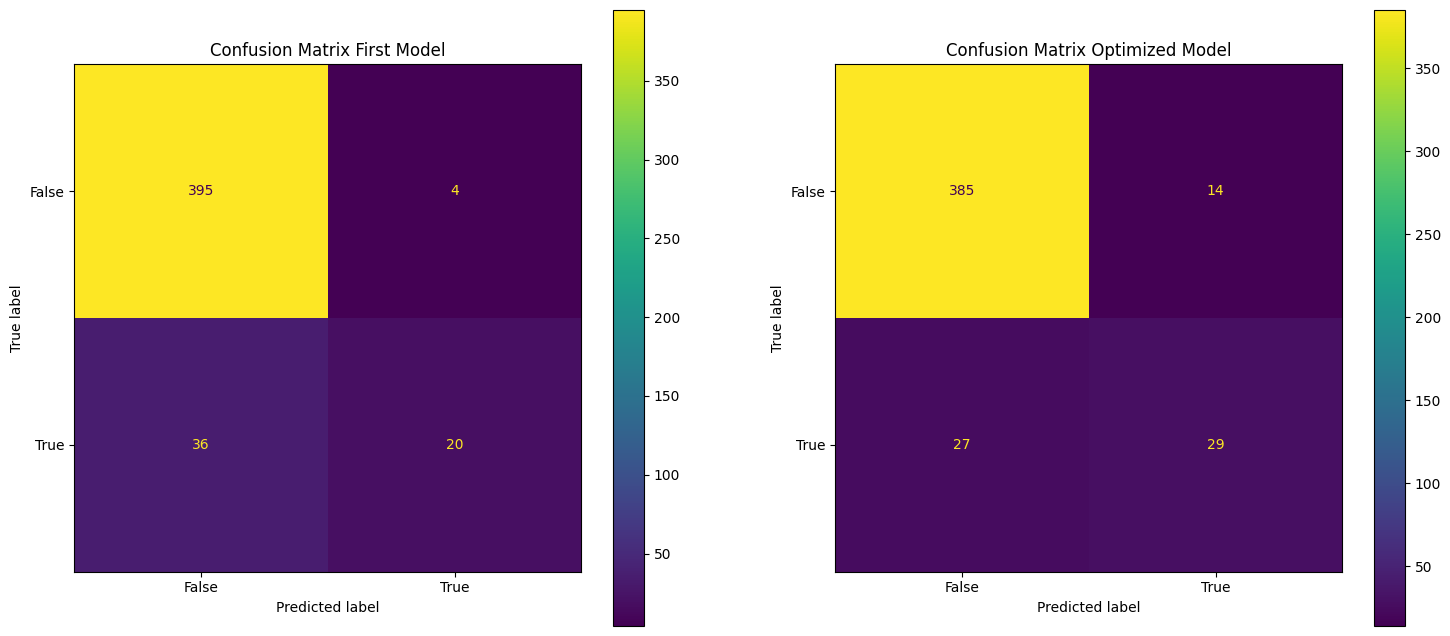

In [535]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
ax[0].set_title('Confusion Matrix First Model')
cm = confusion_matrix(y_test_enc, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax[0])
ax[1].set_title('Confusion Matrix Optimized Model')
cm1 = confusion_matrix(y_test_enc, y_test_pred_opt)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=le.classes_)
disp1.plot(ax=ax[1])

The optimized model presents better results for predicting the True class but at the cost of increasing the false positive results

### Step 5: Save the model
Store the model in the corresponding folder.

In [527]:
dump(model_opt, open('model_opt_kernel=linear_C=10_gamma=0dot01.sav','wb'))